## Small-world measures of the connectivity graph

We are intended to extract the following network metrics:
- clustering degree
- clustering coefficient
- path length: average shortest distance from each node to any other node.
- small-world networks: characterized by higher clustering coefficient and lower path length than random networks. Small-worldedness (SWM) is measured using the following metrics:
    - $\sigma = {{C / C_r} \over {L / L_r}}$, where $r$ refers to a random network. A graph is classified as small-world if $\sigma>1$.
    - $\omega = L_r/L - C/C_l$, where $l$ refers to a lattice network and $r$ refers to a random network. $\omega$ ranges between -1 (lattice) and 1 (random). A graph features small-world characteristics if $\omega$ is close to 0.
    - statistical significance of small-world features.

**Note from Cohen (2014; p. 442):**
simulate $C$ and $L$ with regard to the probability of rewiring from low to high (regular to random). See figure 31.13 in the book.

In [183]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')  # noqa

import networkx as nx
from tqdm import tqdm

from python.acnets.swn import (
  connectome_smallworld_features, plot_clustering_coefficient, permute_swn, swn_permutation_test)


In [94]:
# data: we use average connectivity across all participants

dataset = xr.open_dataset('outputs/julia2018_resting_connectome.nc')

regions = dataset.coords['region'].values.tolist()
subjects = dataset.coords['subject'].values.tolist()

connectomes = pd.DataFrame(
  zip(dataset['all_connectome'].values),
  columns=['connectome'],
  index=dataset.coords['subject'].values.tolist()
)

connectomes.index.name = 'subject'
connectomes['subject_group'] = connectomes.index.to_frame().apply(lambda x: x.str[:4])
connectomes.attrs['regions'] = regions

## Dosenbach2007, Figure 7

Task control network in the brain features a small-world property that can be distinguished from random networks or a regular lattice. Here, we test the alternative hypothesis that task control nodes form a small-world network.

**$H_0$ = Control network does not feature a small-world property.**

But first, let's reproduce the figure 7 from @dosenbach2007. This figure compares the control network to random and regular networks while applying different thresholds to the connectivity matrix.

100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


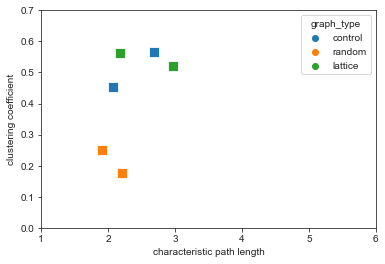

In [162]:
# params
threshold_candidates = [0.2]#, 0.175, 0.15, 0.125, 0.1]


plot_data = [] # list of ('graph_type', r, Cp, Lp)

for thr in tqdm(threshold_candidates):
  metrics = connectomes.groupby('subject_group')['connectome'].apply(
    lambda x: connectome_smallworld_features(x.mean(), thr)
  )
  plot_data.append(metrics)

# convert results to dataframe for easier plotting
plot_data = pd.concat(plot_data).to_frame()
plot_data['C'] = plot_data['connectome'].apply(lambda x: x[0])
plot_data['L'] = plot_data['connectome'].apply(lambda x: x[1])
plot_data.drop(columns=['connectome'], inplace=True)
plot_data = plot_data.reset_index().rename(columns={'level_1':'graph_type'})

# Figure 7
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=plot_data, x='L', y='C', ax=ax, hue='graph_type', marker='s', s=100)
ax.set(xlim=(1,6), ylim=(0,.7), xlabel='characteristic path length', ylabel='clustering coefficient')

# TODO annotate points with their condition name
# TODO bootstrap CI

plt.show()

In [173]:
all_conn_avg = pd.DataFrame(
  connectomes['connectome'].mean(), columns=regions, index=regions
).reset_index().melt('index')
all_conn_avg.columns = ['source', 'target', 'connectivity']
all_conn_avg.query('source != target')
all_conn_avg

,source,target,connectivity
0,R IPS,R IPS,1.000000
1,L IPS,R IPS,0.603929
2,R frontal cortetrue,R IPS,0.311706
3,L frontal cortetrue,R IPS,0.234490
4,R precuneus,R IPS,0.289648
...,...,...,...
1516,R ant fusiform,vmPFC,-0.011533
1517,L ant fusiform,vmPFC,0.006058
1518,R midtemporal,vmPFC,0.026416
1519,L midtemporal,vmPFC,0.030183


## Cohen (2014), Chapter 31

### Replicating figure 31.11
The effect of threshold choice on the network structure can be illustrated by a plot that
shows the relationship between clustering coefficient ($C$) and the threshold ($\text{thr}$).

In the plot below, gray lines correspond to the regions and the black line represents
the average clustering coefficient across all regions.

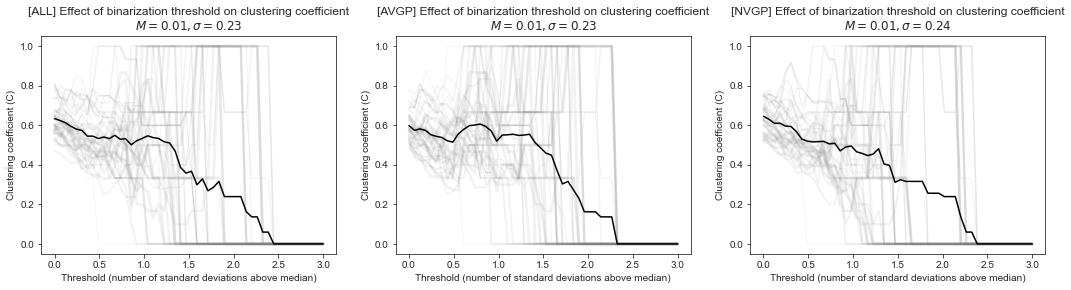

In [175]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,4))

plot_clustering_coefficient(connectomes['connectome'].mean(), label='all', regions=regions, ax=ax1)
plot_clustering_coefficient(connectomes.query('subject_group == "AVGP"')['connectome'].mean(), label='avgp', regions=regions, ax=ax2)
plot_clustering_coefficient(connectomes.query('subject_group == "NVGP"')['connectome'].mean(), label='nvgp', regions=regions, ax=ax3)

plt.show()

### Cohen2014: Replicating figure 31.14

Rewiring the network: 100%|██████████| 10/10 [00:49<00:00,  4.91s/it]


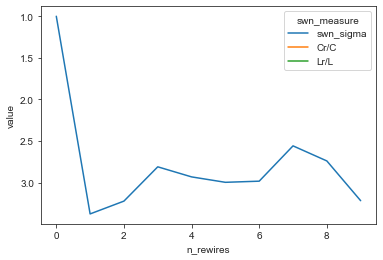

In [177]:
# vmPFC is not connected to any other nodes, so it is not included in the analysis
all_connectome_avg = connectomes['connectome'].mean()
vmPFC_idx = regions.index('vmPFC')
regions_no_vmPFC = np.delete(regions, vmPFC_idx)
conn_no_vmPFC = np.delete(all_connectome_avg, vmPFC_idx, axis=0)
conn_no_vmPFC = np.delete(conn_no_vmPFC, vmPFC_idx, axis=1)

threshold = np.median(conn_no_vmPFC) + np.std(conn_no_vmPFC)
bin_conn = (np.abs(conn_no_vmPFC) >= threshold).astype('int')
G = nx.from_numpy_matrix(bin_conn)  # small-world (task control)

swns = []

max_rewires = 10
for n_rewires in tqdm(range(max_rewires), desc='Rewiring the network'):
  swns.append((n_rewires, nx.smallworld.sigma(G, niter=n_rewires, nrand=10), None, None))

plot_data = pd.DataFrame(swns, columns=['n_rewires','swn_sigma', 'Cr/C','Lr/L'])
plot_data = plot_data.melt(id_vars=['n_rewires'], var_name="swn_measure", value_name="value")

sns.lineplot(data=plot_data, x='n_rewires', y='value', hue='swn_measure')
plt.show()

### Cohen2014: Replicating permutation testing (figure 31.16)

- threshold as X, and Z-scored small-world-ness as Y
- test the statistical significance of the small-world-ness of the network using permutations.

calculating observed SWN...
observed SWN (raw)=3.35
Now simulating random networks...


simulating random networks: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


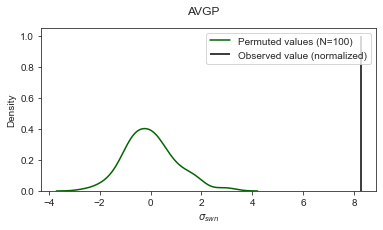

calculating observed SWN...
observed SWN (raw)=1.98
Now simulating random networks...


simulating random networks: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


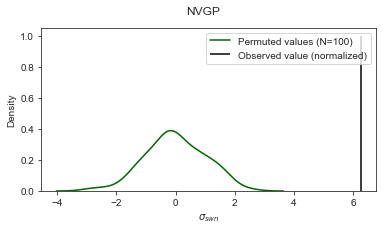

([1.0415506532448062,
  0.9306811332127787,
  1.2959969956603985,
  1.1500356379187455,
  1.1523622239196503,
  0.955011508683825,
  0.7586556456643794,
  0.9182548958805428,
  0.8872843210802701,
  0.9382383936990405,
  1.002118933697881,
  1.122147832555623,
  0.9659516429014259,
  0.8551632245169887,
  1.0069052102950409,
  1.250986050986051,
  1.0715144873302684,
  0.7962452873740096,
  0.8621610601427115,
  0.9903451387322354,
  1.0344837261503927,
  0.8058270841236029,
  1.0213641983964106,
  0.9403982058149665,
  0.9563334536268493,
  1.0722981366459627,
  0.78067140168761,
  1.3699857462838527,
  1.239862757330006,
  1.106947305648921,
  0.7896726314329311,
  0.8801534407935524,
  0.9285107067365133,
  1.2052263872094586,
  1.1179411764705882,
  1.087175425694405,
  1.0918577307466197,
  1.1100867308611624,
  0.9962940086473133,
  1.1994771241830067,
  1.0104232469993686,
  1.011808576755749,
  1.0825531914893618,
  1.2198922817211957,
  0.8490467211397446,
  0.6642021022455806

In [202]:
all_connectome_avg = connectomes['connectome'].mean()
avgp_connectome_avg = connectomes.query('subject_group == "AVGP"')['connectome'].mean()
nvgp_connectome_avg = connectomes.query('subject_group == "NVGP"')['connectome'].mean()

# swn_permutation_test(all_connectome_avg, n_simulations=100, plot=True, title='ALL')
swn_permutation_test(avgp_connectome_avg, n_simulations=100, plot=True, title='AVGP')
swn_permutation_test(nvgp_connectome_avg, n_simulations=100, plot=True, title='NVGP')
